In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm
from tqdm import tqdm
from contextlib import redirect_stdout
import io


import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

## Load masks

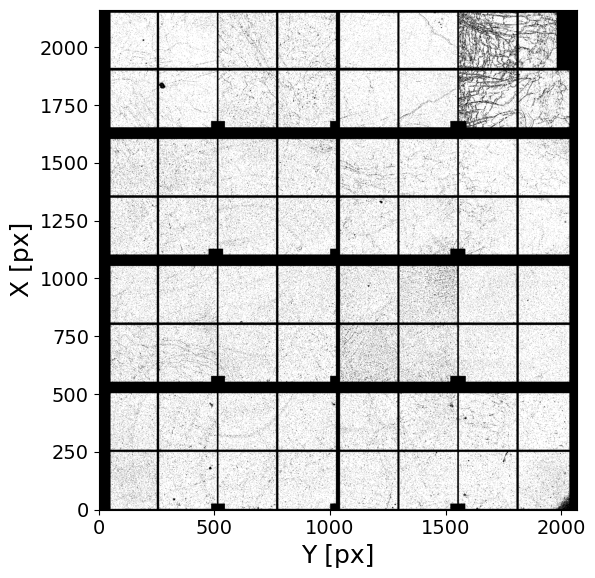

In [2]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

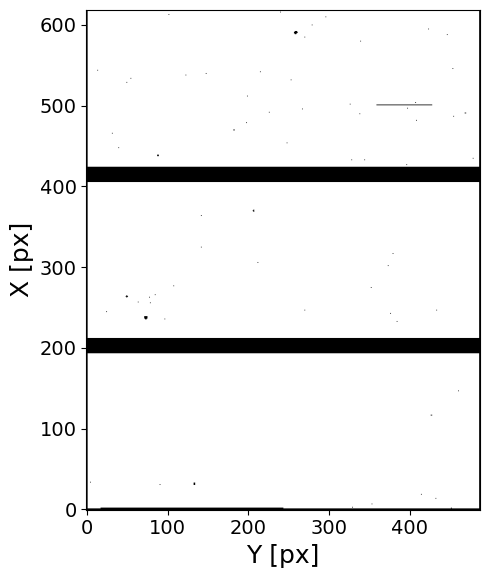

In [3]:
pilatus_mask = np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy').astype(bool)

plt.figure(figsize=(6, 6))
plt.imshow(~pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [7]:
###########
Q = 0.75
dq = 0.05
###########
Q=float(Q)

## XPCS scan: delcoup=3.5, T=4h (Ta2O5_2.5um_asdep, 4, 6)  

Tantala as deposited

#############################
command = mtimescan 0.001 1 16000128
Ei = 21.669991317784486
itime = 0.0011
T =  4.888928 h
theta = 3.499999999999999
Qc = 0.67
#############################



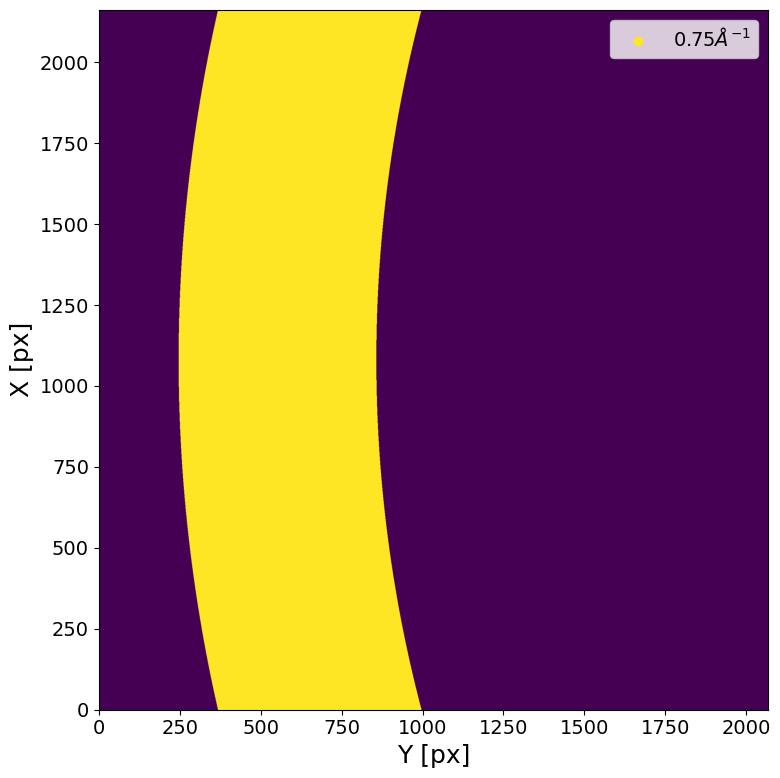

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00032.h5 (33/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00043.h5 (44/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00044.h5 (45/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00046.h5 (47/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00047.h5 (48/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00048.h5 (49/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00049.h5 (50/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/1001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/1001 loops)
	 -> loadi

In [32]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 4
Nscan = 6
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(5e6)
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  3418436 pixels (of 4471016 => 76.46 %)
# of pixels below Ith_low treshold ->  30663 pixels (of 4471016 => 0.69 %)
################################################################################



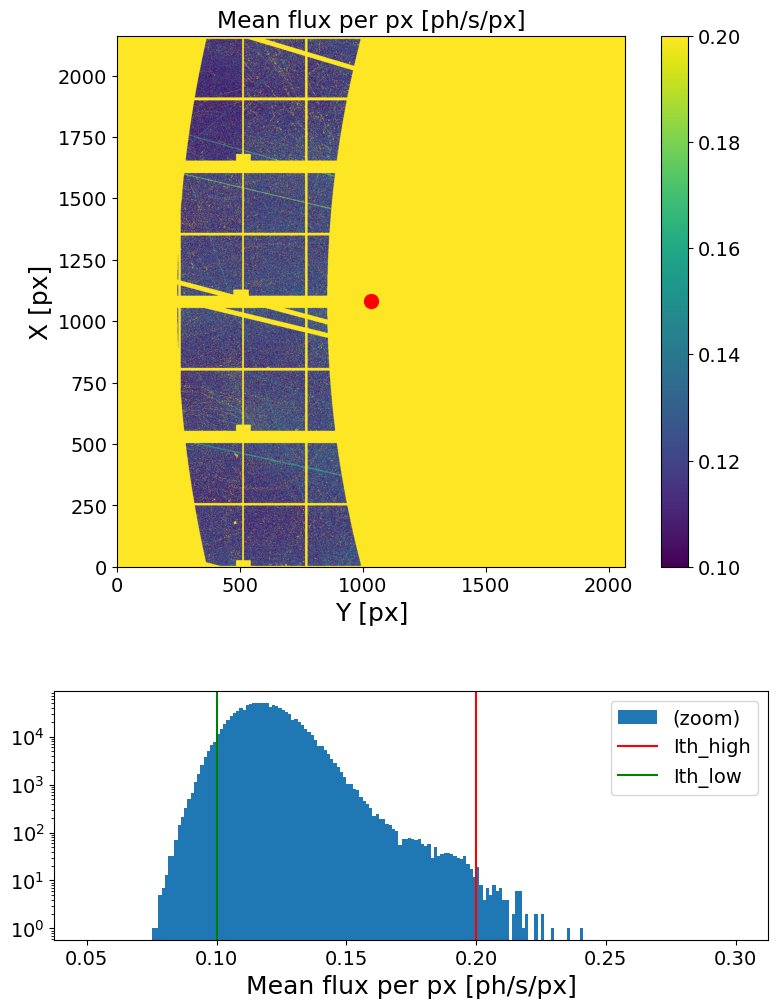

In [33]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.1, Ith_high=0.2, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [34]:
####################
Lbin = 1000
Nstep = 1000
mask = None#e4m_mask*e4m_htmask*Qmask#None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
#t_It1, It1 = XPCS.get_It(e4m_data, itime, mask=e4m_mask*e4m_htmask*Qmask1, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

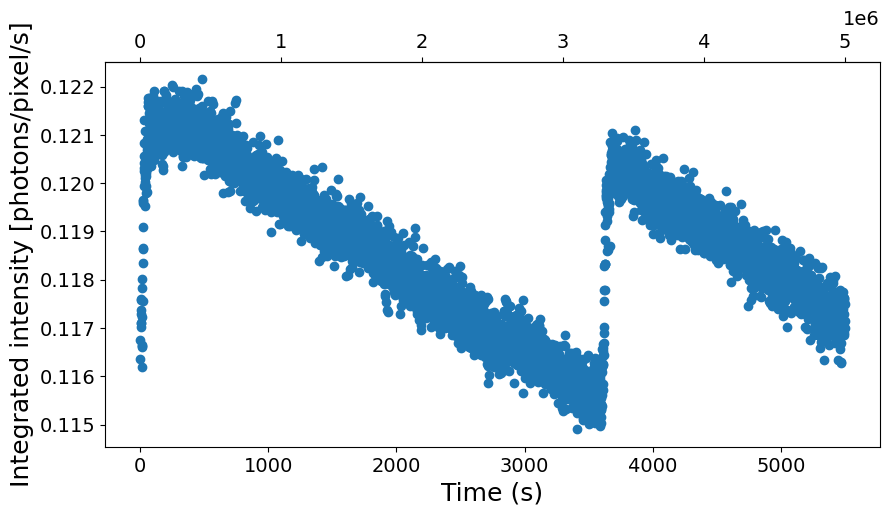

In [35]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
#plt.scatter(t_It1, It1, label='It1', color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
#plt.xlim(0,500)
plt.show()

### Linear correlation 4 tests

In [65]:
###################
Nfi = None
Nff = int(5e6)
Lbin = 1000
bin2dense = True
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 1000, using MKL library) ...


Done! (elapsed time = 1.14 s)
	 | 5000 frames X 1052674 pixels
	 | memory usage (np.array @ float32) = 19.608 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 7.64 s)
	 | 5000 X 5000 squared matrix
	 | memory usage (np.array @ float32) = 0.093 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.94 s)



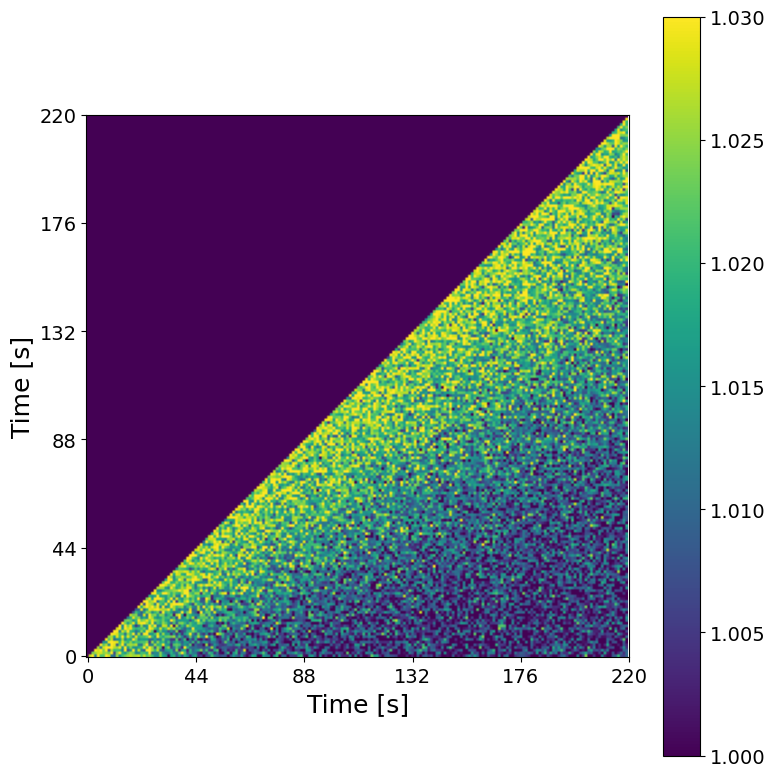

In [60]:
############################
t1, t2 = 0, 3000
vmin, vmax = 1.0, 1.03
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [66]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.02 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


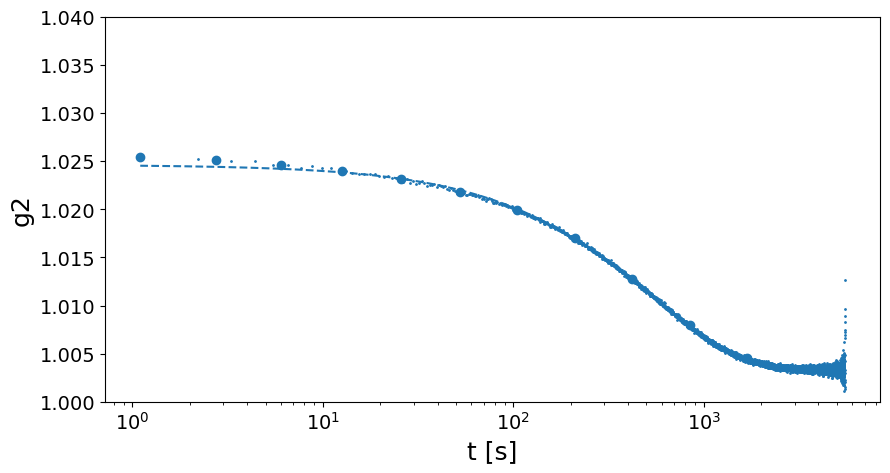

name,value,standard error,relative error,initial value,min,max,vary
tau,529.506604,0.91072166,(0.17%),1000,0.00000000,1000000.00,True
beta,0.88140807,0.00146323,(0.17%),1,0.00000000,2.00000000,True
c,0.02151699,2.3093e-05,(0.11%),0.02,0.00000000,1.00000000,True
y0,1.00310482,0.00000000,(0.00%),1.00310482,-inf,inf,False


In [67]:
##################
t1_fit = 0
t2_fit = 1e100
##################
#############################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00310482, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.errorbar(t_mt[k], g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]


    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.04)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [18]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 500000  =>  t_ff = 550.0
#############################



In [19]:
########################################
#N_segments = 5
t_segments = [0, 50, 200, 500]#, 1000]#[0, 1000, 5000, 16000] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [20]:
###################
Lbin = 100
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


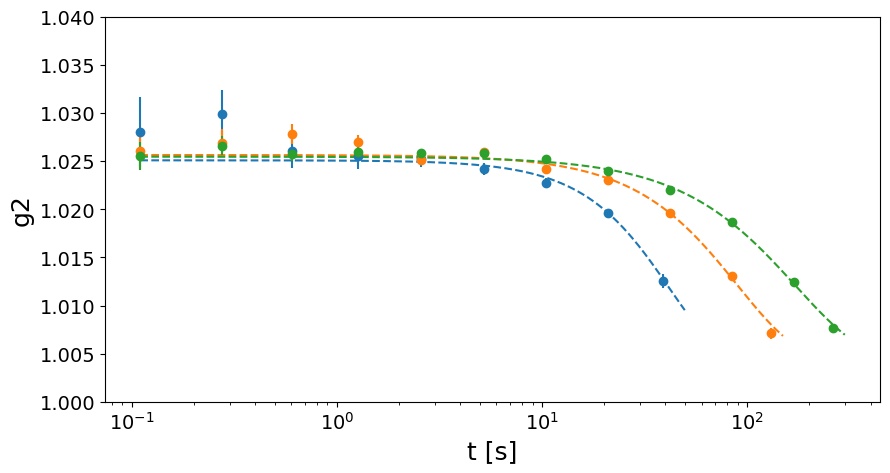

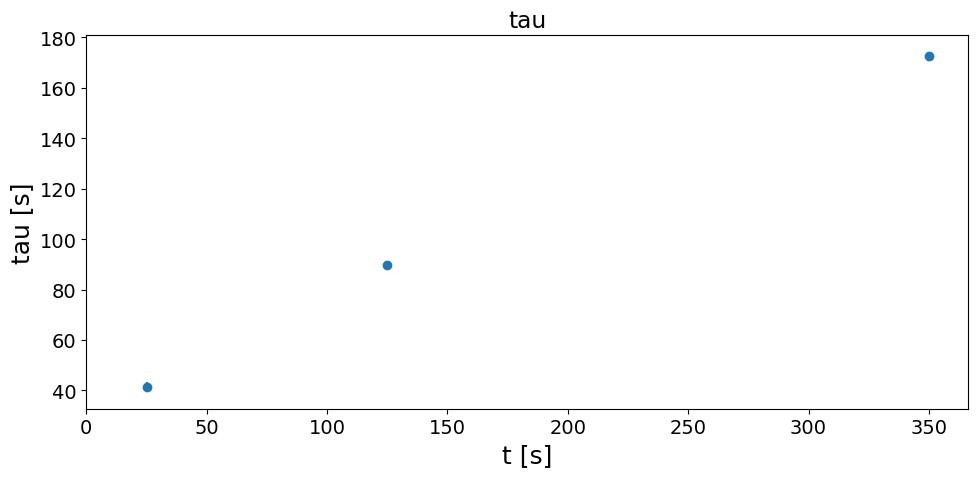

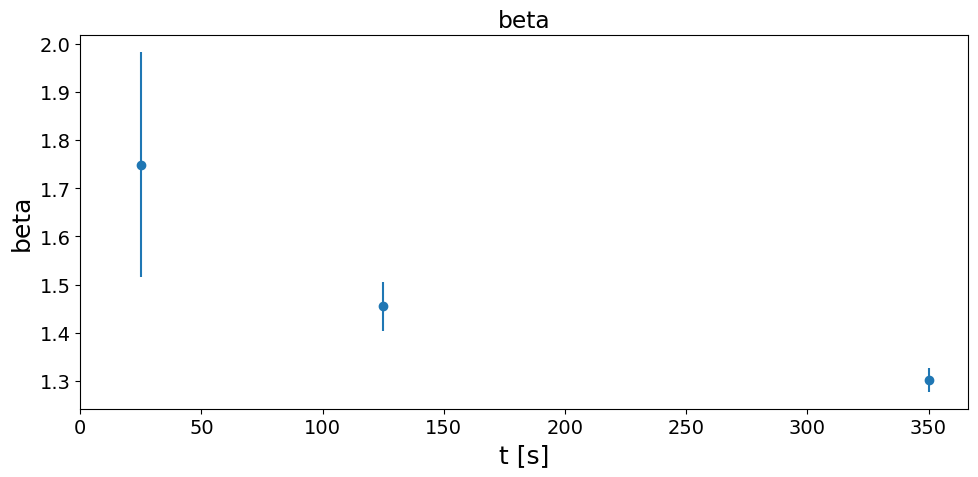

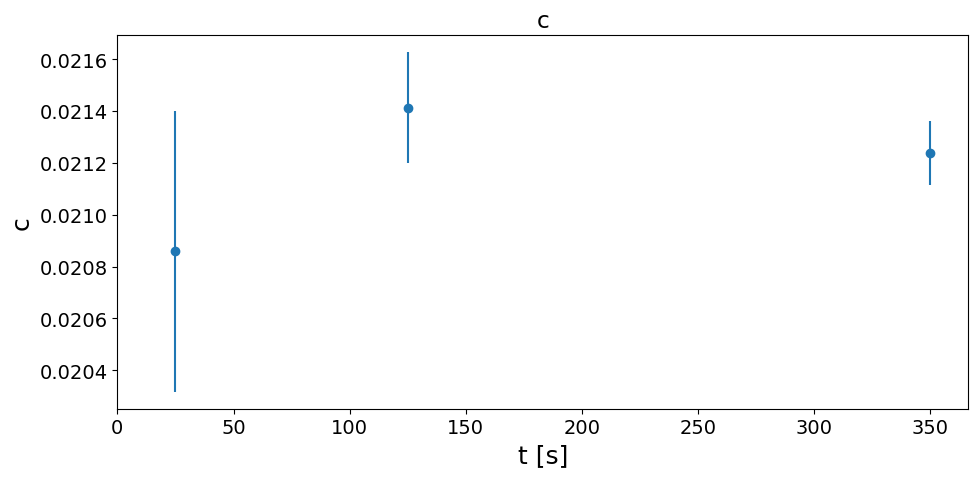

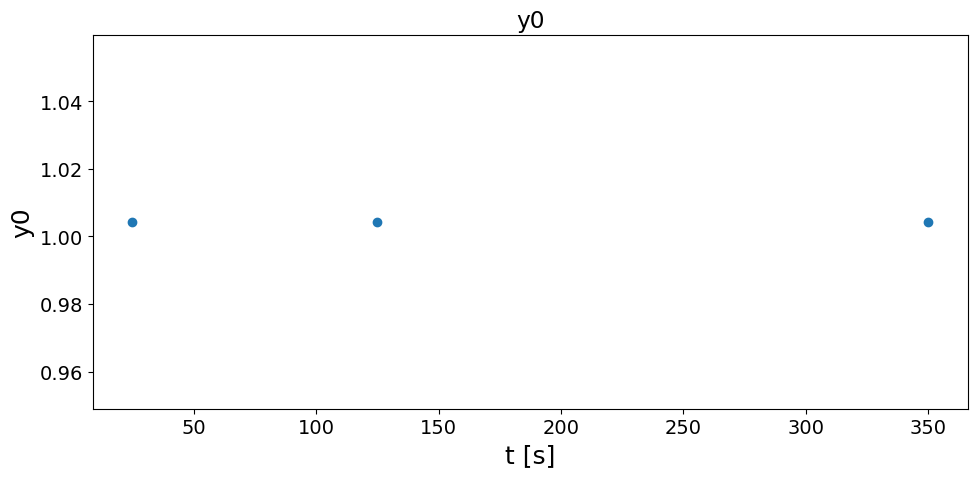

In [21]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.00423417, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.04)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

### Multi-tau Correlation (TO BE REORDER!!!)

In [6]:
XPCS.print_Nf_choices(len(scan['fast_timer_period']))

       Nf = 16000128    =>    log2(Nf) = 23.93
----------------------------------------------------
   reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0       2**23                 22             47.6        7611520
1     3*2**22                 21             21.0        3417216
2     7*2**21                 20              8.0        1320064
3    15*2**20                 19              2.0         271488
4    61*2**18                 17              0.0           9344
5  1953*2**13                 12              0.0           1152
----------------------------------------------------


In [163]:
##### INPUTS #####
Nfi = 0
Nff = Nfi + 2**15
sparse_depth = 13
dense_depth = 14
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth, Nfi, Nff, mask=None)
#G2tmt = XPCS.get_G2tmt_4sparse_bypartialloading(RAW_folder, sample_name, Ndataset, Nscan, sparse_depth, dense_depth, Nfi, Nff, mask = load_mask, n_jobs=1)
t_g2_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

Loading frames ...
Done! (elapsed time = 0.01 s)
	 | 32768 frames X 210979 pixels
	 | sparsity = 1.30e-04
	 | memory usage (sparse.csr_array @ float32) = 0.01 GB
Computing sparse multitau G2t...


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


Done! (elapsed time = 2.89 s)
Computing dense multitau G2t...


100%|██████████| 1/1 [00:00<00:00, 1283.05it/s]

Done! (elapsed time = 0.0 s)


In [164]:
Lbin=1

G2t = XPCS.get_G2t(e4m_data,  Nfi=Nfi, Nff=Nff, mask=None, Lbin=Lbin)
t_g2, g2, dg2 = XPCS.get_g2(itime*Lbin, G2t)

Loading frames ...
Done! (elapsed time = 0.01 s)
Computing G2t (using MKL library)...
Done! (elapsed time = 1.71 s)
	 | 32768 X 32768 squared matrix
	 | memory usage (np.array @ float32) = 4.0 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 1.64 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.54 s)



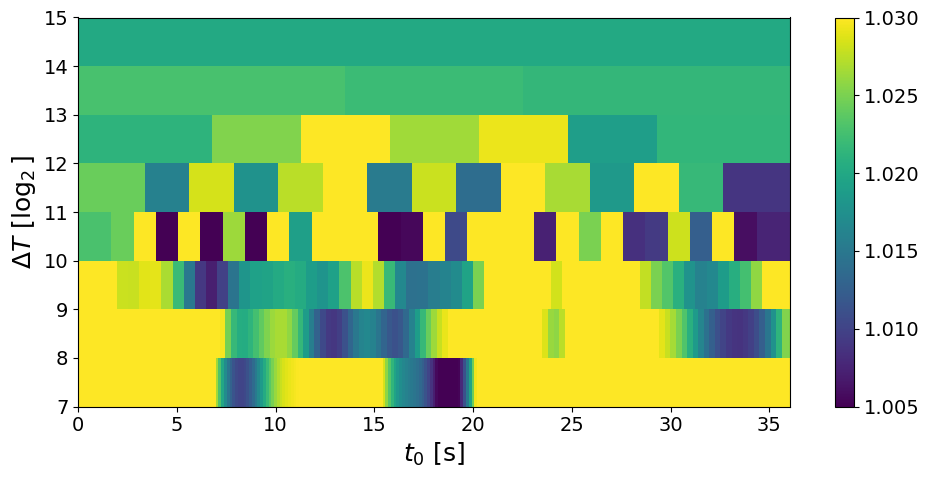

In [165]:
############################
vmin, vmax = 1.005, 1.03
lower_mt = 7
filter_layer = 10
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log2', lower_mt=lower_mt, filter_layer=filter_layer)

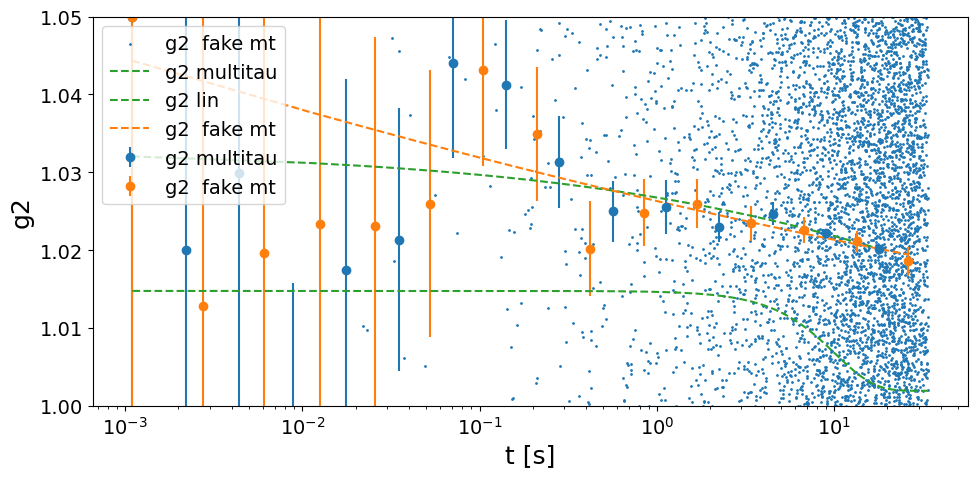

name,value,standard error,relative error,initial value,min,max,vary
tau,147.114137,90.2696622,(61.36%),50,0.00000000,1000000.00,True
beta,0.30248450,0.25760920,(85.16%),0.8,0.00000000,2.00000000,True
c,0.03096170,0.01109658,(35.84%),0.02,0.00000000,1.00000000,True
y0,1.00192874,0.00000000,(0.00%),1.00192874,-inf,inf,False


name,value,standard error,relative error,initial value,min,max,vary
tau,4.0366e-08,1.5266e-05,(37817.89%),50,0.00000000,1000000.00,True
beta,0.04428951,0.35735834,(806.87%),0.8,0.00000000,2.00000000,True
c,0.20417119,3.59480914,(1760.68%),0.02,0.00000000,1.00000000,True
y0,1.00192874,0.00000000,(0.00%),1.00192874,-inf,inf,False


name,value,standard error,relative error,initial value,min,max,vary
tau,10.2016530,1.86779178,(18.31%),50,0.00000000,1000000.00,True
beta,1.99999997,1.06906335,(53.45%),0.8,0.00000000,2.00000000,True
c,0.01282709,0.00230214,(17.95%),0.02,0.00000000,1.00000000,True
y0,1.00192874,0.00000000,(0.00%),1.00192874,-inf,inf,False


In [166]:
##################
t1_fit = 1e-1
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=1, max=2)
params.add('y0', value=1.00192874, vary=False)
#####################################################

# PLOT
plt.figure(figsize=(10,5))
plt.errorbar(t_g2_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2 multitau')

# PLOT2
plt.scatter(t_g2, g2, s=1, c='C0', label='g2  fake mt')
t_g2_log2, g2_log2, dg2_log2 = XPCS.get_g2mt_fromling2(itime*Lbin, g2, dg2)
plt.errorbar(t_g2_log2, g2_log2, yerr=dg2_log2, fmt='o', label='g2  fake mt')

# FIT
x = t_g2_mt [(t1_fit<t_g2_mt)*(t_g2_mt<t2_fit)]
y = g2_mt   [(t1_fit<t_g2_mt)*(t_g2_mt<t2_fit)]
dy = dg2_mt [(t1_fit<t_g2_mt)*(t_g2_mt<t2_fit)]
dy[-1] = dy[-2]
fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
x = np.arange(np.min(t_g2_mt), np.max(t_g2_mt), 1e-2)
y = decorrelation_f(x, *fit.params.values())
plt.plot(x, y, c='C'+str(i), linestyle='--', label='g2 multitau')

# FIT3
x = t_g2 [(t1_fit<t_g2)*(t_g2<t2_fit)]
y = g2   [(t1_fit<t_g2)*(t_g2<t2_fit)]
dy = dg2 [(t1_fit<t_g2)*(t_g2<t2_fit)]
fit3 = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
x = np.arange(np.min(t_g2), np.max(t_g2), 1e-2)
y = decorrelation_f(x, *fit3.params.values())
plt.plot(x, y, c='C2', linestyle='--', label='g2 lin')


# FIT2 
x = t_g2_log2 [(t1_fit<t_g2_log2)*(t_g2_log2<t2_fit)]
y = g2_log2   [(t1_fit<t_g2_log2)*(t_g2_log2<t2_fit)]
dy = dg2_log2 [(t1_fit<t_g2_log2)*(t_g2_log2<t2_fit)]
fit2 = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
x = np.arange(np.min(t_g2_log2), np.max(t_g2_log2), 1e-2)
y = decorrelation_f(x, *fit2.params.values())
plt.plot(x, y, c='C1', linestyle='--', label='g2  fake mt')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1.0, 1.05)
plt.legend()
plt.tight_layout(); plt.show()

display(fit.params)
display(fit2.params)
display(fit3.params)

In [167]:
t_segments = [0, 50, 200, 500, 1000]#[0, 500, 1500, 4000, Nff*itime]

cuts, t_g2_mt_cuts, g2_mt_cuts, dg2_mt_cuts = {}, {}, {}, {}
for i in range(len(t_segments)-1):
    t1 = t_segments[i]
    t2 = t_segments[i+1]
    T = t1+ (t2-t1)/2
    cuts[T] = XPCS.cut_G2tmt(itime, G2tmt, tmin=t1, tmax=t2)
    t_g2_mt_cuts[T], g2_mt_cuts[T], dg2_mt_cuts[T] = XPCS.get_g2mt(itime, cuts[T])

In [159]:
t_g2_mt_cuts[25][14]

np.float64(18.0224)

/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/lmfit/minimizer.py:819: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/lmfit/minimizer.py:826: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:116: RuntimeWarning: invalid value encountered in sqrt
  std_devs = numpy.sqrt(numpy.diag(covariance_mat))
/data/visitor/hc6211/id10-coh/20250527/mi

ValueError: zero-size array to reduction operation minimum which has no identity

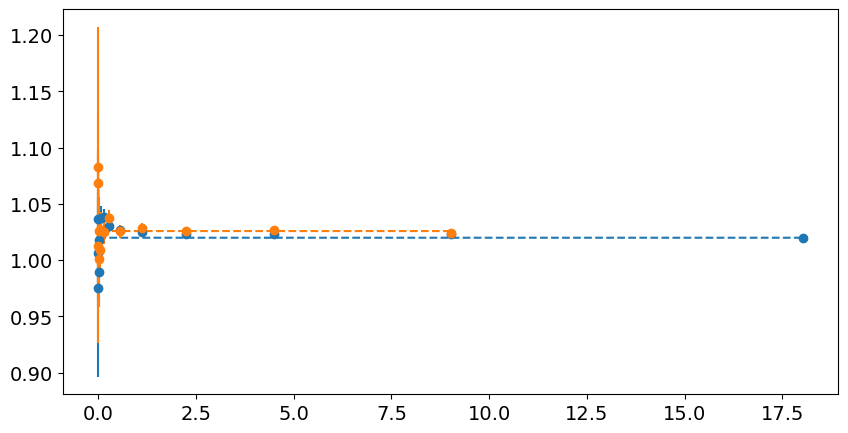

In [160]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=1, max=2)
#params.add('y0', value=1.00192874, vary=False)
#####################################################

g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'

# PLOT
plt.figure(figsize=(10,5))
for i,k in enumerate(t_g2_mt_cuts.keys()):
    plt.errorbar(t_g2_mt_cuts[k], g2_mt_cuts[k], yerr=dg2_mt_cuts[k], fmt='o', label=str(k)+'s')

    # FIT
    x = t_g2_mt_cuts[k] [(t1_fit<t_g2_mt_cuts[k])*(t_g2_mt_cuts[k]<t2_fit)]
    y = g2_mt_cuts[k][(t1_fit<t_g2_mt_cuts[k])*(t_g2_mt_cuts[k]<t2_fit)]
    dy = dg2_mt_cuts[k][(t1_fit<t_g2_mt_cuts[k])*(t_g2_mt_cuts[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares')#, weights=1/dy)
    x = np.arange(np.min(t_g2_mt_cuts[k]), np.max(t_g2_mt_cuts[k]), 1e-2)
    y = decorrelation_f(x, *fit.params.values())
    plt.plot(x, y, c='C'+str(i), linestyle='--')
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

   

plt.xlabel('t [s]')
plt.ylabel('g2')
#plt.xscale('log')
plt.ylim(1, 1.04)
plt.legend()
plt.xlim(1)
plt.tight_layout(); plt.show()
'''
plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()
'''

## XPCS scan: delcoup=3.5, T=24h (Ta2O5_2.5um_B, 1, 3)  

Tantala annealed

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  7.448131166666667 h
theta = 3.499999999999999
Qc = 0.67
#############################



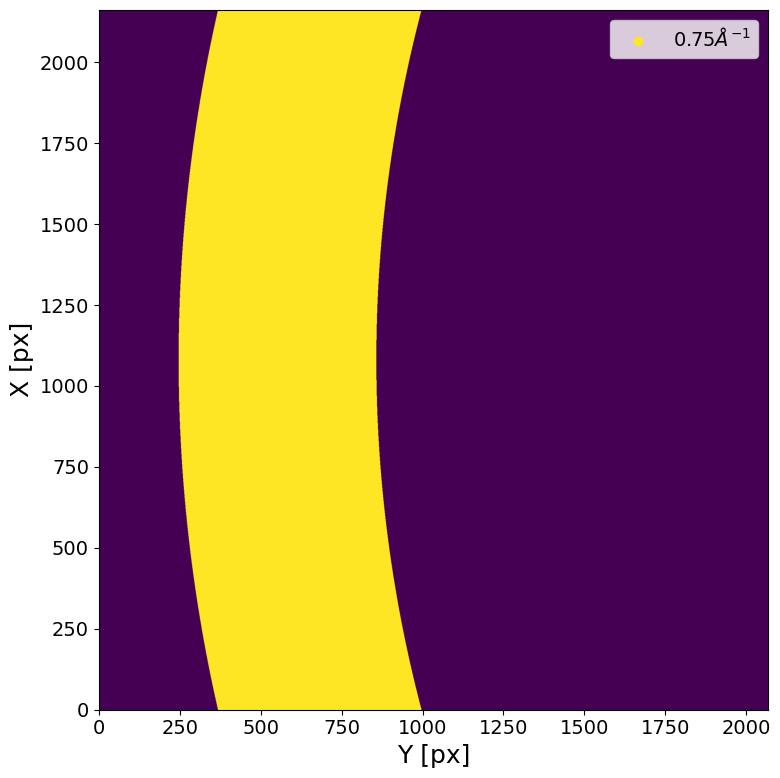

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/2001 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/2001 loops)
	 -> loading file

In [6]:
#######################################
sample_name = 'Ta2O5_2.5um_B'
Ndataset = 1
Nscan = 3
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e7)#len(scan['fast_timer_period']) -5001
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  3396979 pixels (of 4471016 => 75.98 %)
# of pixels below Ith_low treshold ->  23 pixels (of 4471016 => 0.0 %)
################################################################################



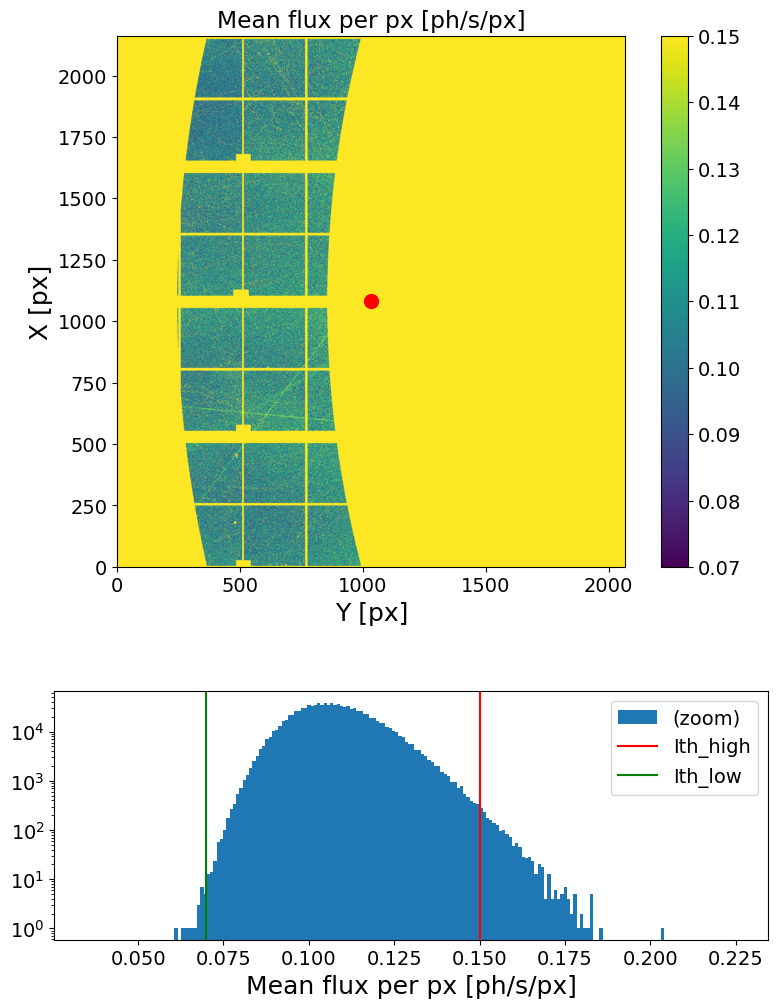

In [9]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.07, Ith_high=0.15, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [7]:
####################
Lbin = 1000
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

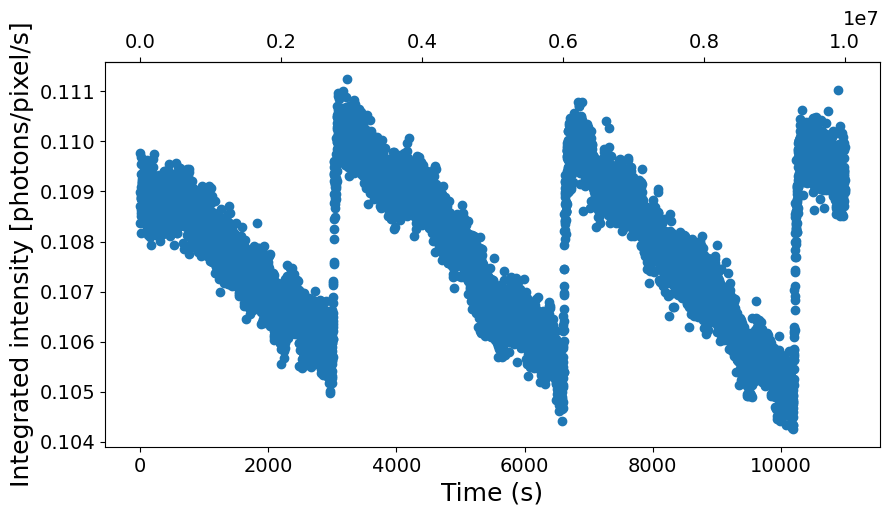

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
#plt.xlim(0,500)
plt.show()

### Linear correlation 4 tests

In [9]:
###################
Nfi = None
Nff = int(1e7)
Lbin = 300
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.0 s)
Binning frames (Lbin = 300, using MKL library) ...


Done! (elapsed time = 16.78 s)
	 | 33333 frames X 1075846 pixels
	 | sparsity = 3.49e-02
	 | memory usage (sparse.csr_array @ float32) = 14.002 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 113.53 s)
	 | 33333 X 33333 squared matrix
	 | memory usage (np.array @ float32) = 4.139 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.42 s)



In [10]:
############################
t1, t2 = 0, 3000
vmin, vmax = 1.0, 1.03
############################
#XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=6)

In [11]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t_g2, g2, dg2, t_mt, g2_mt, dg2_mt = {}, {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]))
    else:         t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
    t_mt[t_bunch], g2_mt[t_bunch], dg2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch],dg2[t_bunch])   


Computing g2 (using cython code)...
Done! (elapsed time = 0.55 s)



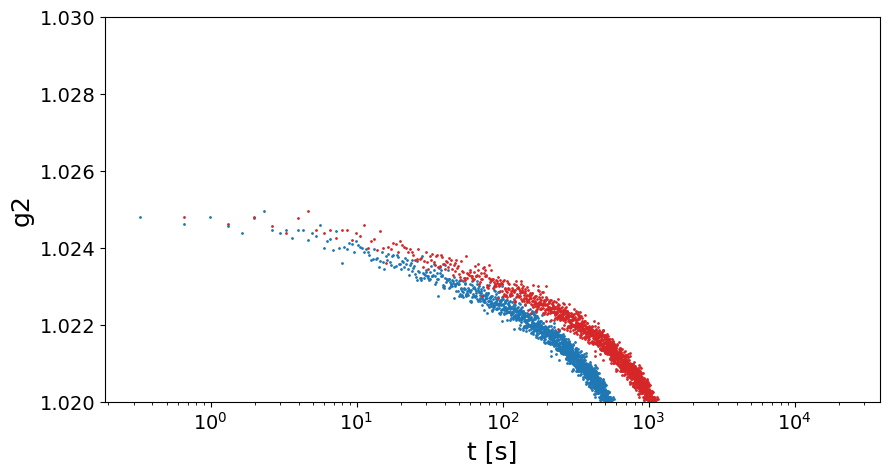

name,value,standard error,relative error,initial value,min,max,vary
tau,2393.05993,1.32724083,(0.06%),1000,0.00000000,1000000.00,True
beta,1.15697889,0.00110295,(0.10%),1,0.00000000,2.00000000,True
c,0.01908518,9.8462e-06,(0.05%),0.02,0.00000000,1.00000000,True
y0,1.00400336,4.6849e-06,(0.00%),1,0.00000000,2.00000000,True


Exception ignored in: <function ResourceTracker.__del__ at 0x7f6835f97c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f3b1275bc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [ ]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
params.add('y0', value=1, min=0, max=2)
#params.add('y0', value=1.001, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_g2[k]*2, g2[k], s=1,  c='C3', label = str(k)+'s')
    #plt.errorbar(t_mt[k], g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C'+str(i), label=str(k)+'s')
    #plt.errorbar(t_mt[k]*2, g2_mt[k], yerr = dg2_mt[k],fmt = 'o', c='C3', label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]


    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    #plt.plot(x, y, c='C'+str(i), linestyle='--')
    #plt.plot(x, y, c='C'+str(i), linestyle='--')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1.02, 1.03)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [12]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 21619209  =>  t_ff = 23781.1299
#############################



In [ ]:
########################################
#N_segments = 5
t_segments = [0, 7000, 10000, 12000, 15000, 17000, 20000, t_ff] #np.linspace(0, int(t_ff), N_segments)
t_skip = [] # skip if Nfi is in t_skip
########################################

Nf_segments = [int (t/itime) for t in t_segments]
Nf_skip = [int(t/itime) for t in t_skip]

In [14]:
###################
Lbin = 1000
bin2dense = True
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments)-1)):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i]
        Nff = Nf_segments[i+1]
        if not Nfi in Nf_skip:
            G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)
            t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
            t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t))
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2, dg2=dg2)

100%|██████████| 6/6 [01:01<00:00, 10.32s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

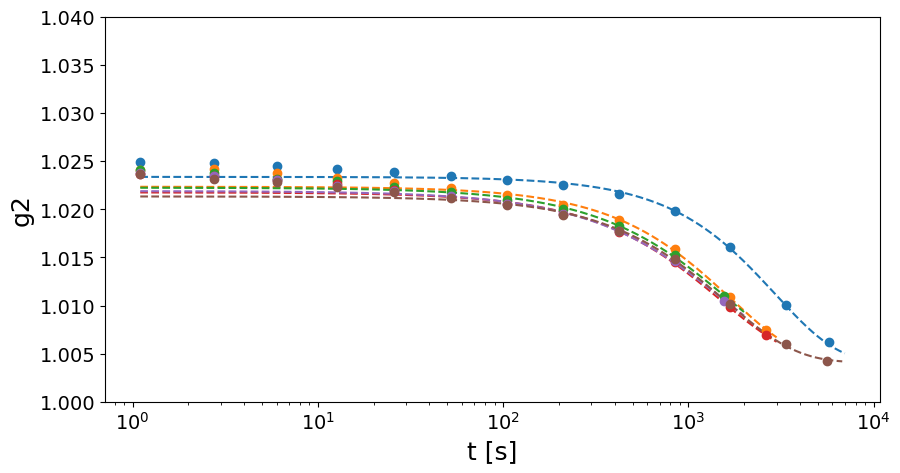

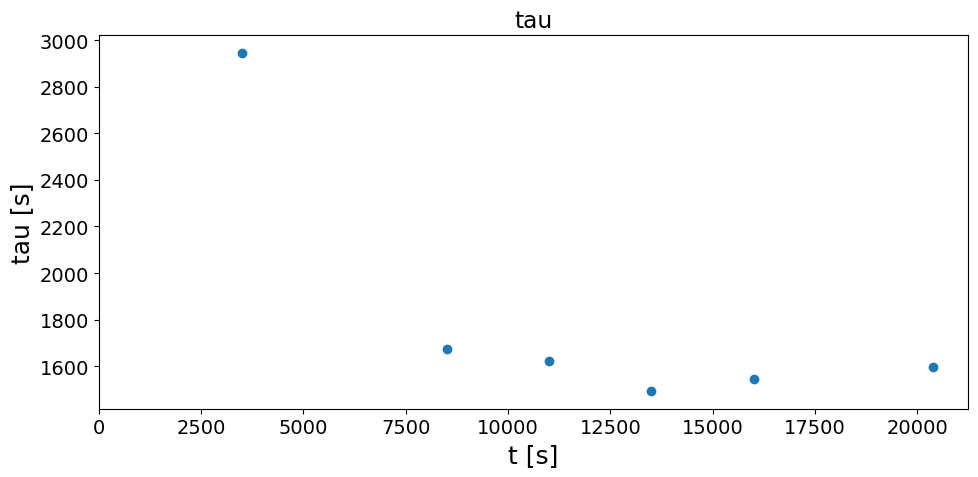

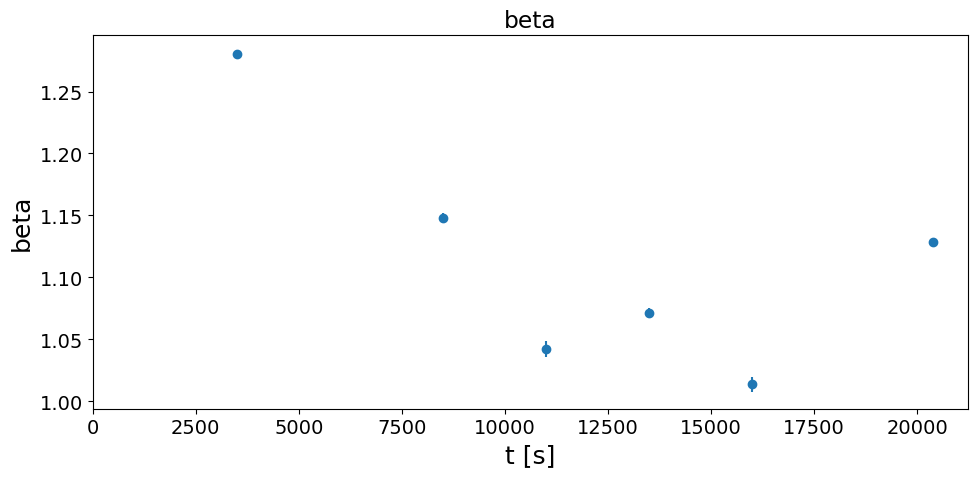

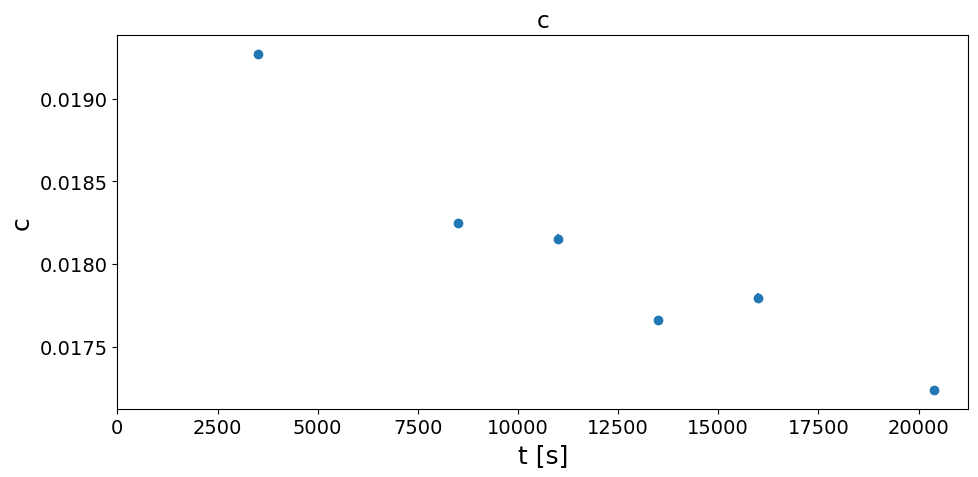

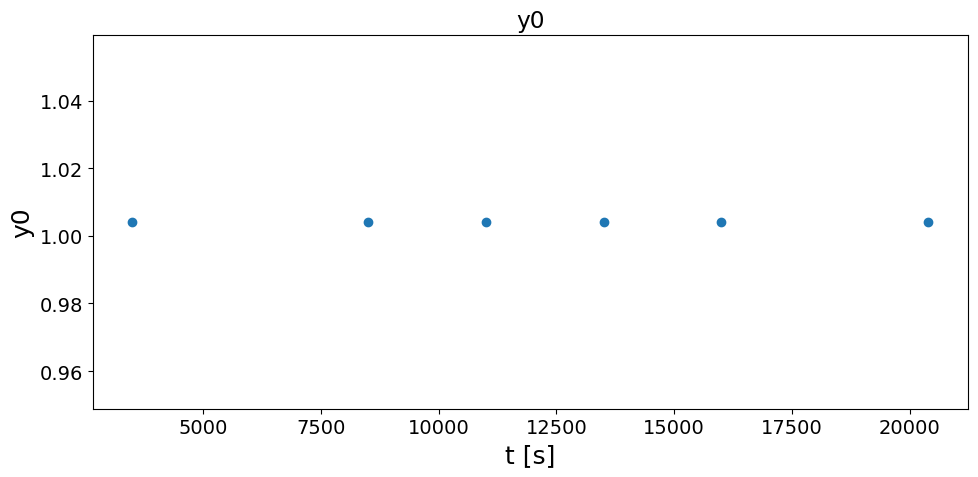

Exception ignored in: <function ResourceTracker.__del__ at 0x7b9dd5f4bce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x755d7d197ce0>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [15]:
##################
t1_fit = 0
t2_fit = 1e10
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=50, min=0, max=1e6)
params.add('beta', value=0.8, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.0041, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    #plt.scatter(t_g2[k], g2[k], s=1, c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt, dg2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k], dg2[k])
    plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt = 'o', c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    dy = dg2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x, method='least_squares', weights=1/dy)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k]), np.max(t_g2[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y, c='C'+str(i), linestyle='--')

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.04)
#plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

## I(Q) comparison between annealed and as deposited

### Generate Qmask

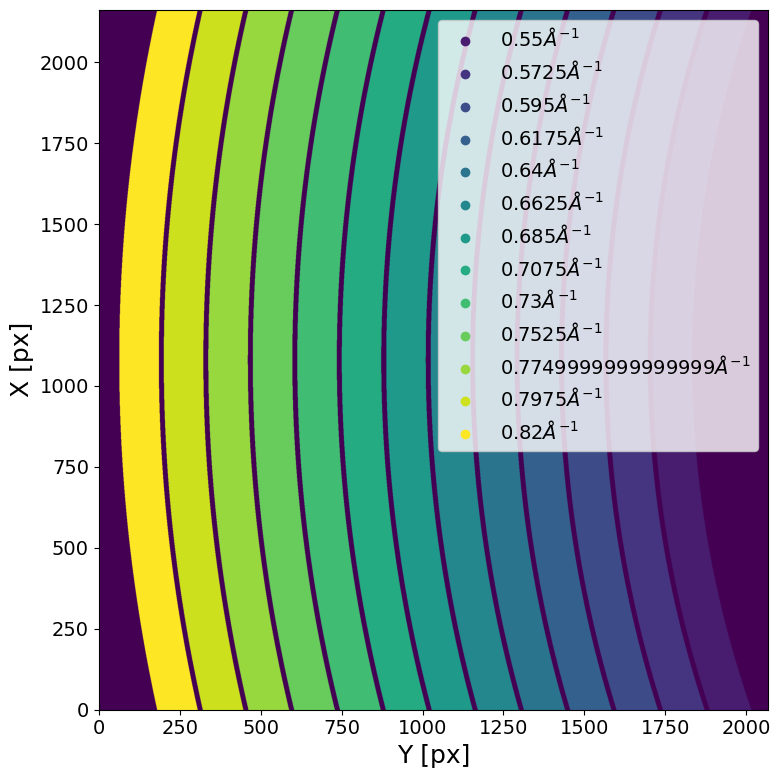

In [10]:
Q = np.linspace(0.55,0.82,13)
dq = 0.01

Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)

### Annealed virgin: XPCS scan: delcoup=3.5, T=4h (Ta2O5_2.5um_B, 1, 3)

In [6]:
#######################################
sample_name = 'Ta2O5_2.5um_B'
Ndataset =1
Nscan = 3
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None #e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  7.448131166666667 h
theta = 3.499999999999999
Qc = 0.67
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_fr

################################################################################
Maximum count in the whole run -> 5.0
# of pixels above Ith_high treshold ->  56607 pixels (of 4471016 => 1.27 %)
# of pixels below Ith_low treshold ->  1302685 pixels (of 4471016 => 29.14 %)
################################################################################



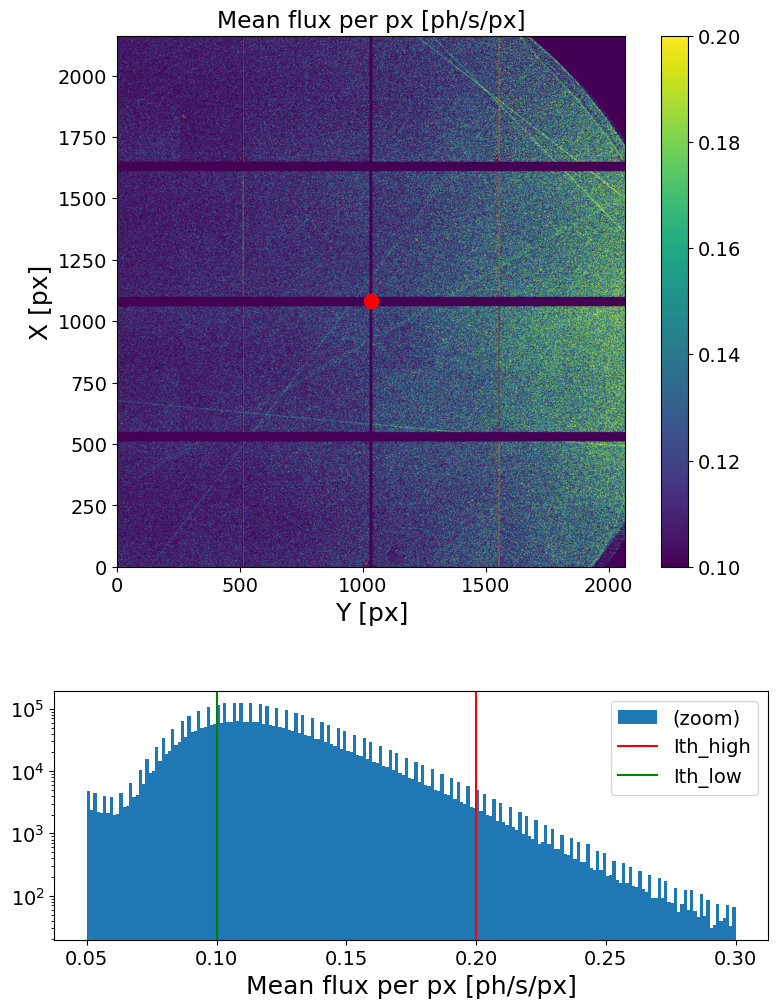

In [12]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.1, Ith_high=0.2, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

In [11]:
########################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
########################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_ann = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)    ######## media temporale
    Ip_ann[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel

  8%|▊         | 1/13 [00:05<01:02,  5.24s/it]Exception ignored in: <function ResourceTracker.__del__ at 0x7f359af2fc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe00add7c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/pytho

KeyboardInterrupt: 

### Annealed danneggiato: XPCS scan: delcoup=3.5, T=4h (Ta2O5_2.5um_B, 1, 3)

In [ ]:
#######################################
sample_name = 'Ta2O5_2.5um_B'
Ndataset =1
Nscan = 3
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = len(scan['fast_timer_trig'])-int(1e6), len(scan['fast_timer_trig'])
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None #e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  10.316667166666669 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_03000.h5 (3001/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03049.h5 (3050/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03050.h5 (3051/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03051.h5 (3052/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03052.h5 (3053/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03053.h5 (3054/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03054.h5 (3055/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03055.h5 (3056/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03056.h5 (3057/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03057.h5 (3058/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_03059.h5 (3060/201 loops)
	 -> 

In [ ]:
########################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
########################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_ann_damaged = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)    ######## media temporale
    Ip_ann_damaged[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel

100%|██████████| 11/11 [01:38<00:00,  8.93s/it]


### As-deposited virgin: XPCS scan: delcoup=3.5, T=4h (Ta2O5_2.5um_asdep, 4, 6)  

In [ ]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =4
Nscan = 6
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, int(1e6)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None #e4m_mask*e4m_htmask*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 1 16000128
Ei = 21.669991317784486
itime = 0.0011
T =  4.888928 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...


	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00048.h5 (49/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00049.h5 (50/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00055.h5 (56/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00059.h5 (60/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00060.h5 (61/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00061

In [ ]:
##############################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
##############################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_asdep = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)     ######## media temporale
    Ip_asdep[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel


100%|██████████| 11/11 [00:39<00:00,  3.58s/it]


### As-deposited danneggiato: XPCS scan: delcoup=1.7, T=4h (Ta2O5_2.5um_asdep, 4, 6)  

In [ ]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset =4
Nscan = 6
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = len(scan['fast_timer_period'])-int(1e6), len(scan['fast_timer_period'])
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = None # e4m_mask*e4m_htmask#*Qmask*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

#############################
command = mtimescan 0.001 2 86000367
Ei = 21.669991317784486
itime = 0.0011
T =  3.3802202500000003 h
theta = 1.6999999999999993
Qc = 0.33
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00049.h5 (50/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00053.h5 (54/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00054.h5 (55/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00056.h5 (57/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00057.h5 (58/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00058.h5 (59/201 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00059.h5 (60/201 loops)
	 -> loading file eiger4m_v2

In [ ]:
##############################################
Nfi = None
Nff = int(1e6)

mask = e4m_mask*e4m_htmask*Kossel_mask
##############################################
if Nfi is None: Nfi = 0
if Nff is None: Nff = e4m_data.shape[0]

Ip_asdep_damaged = {}
for i in tqdm(list(Qmask.keys())):
    Idt =      e4m_data[Nfi:Nff,mask*Qmask[i]].sum(axis=0)/((Nff-Nfi)*itime)     ######## media temporale
    Ip_asdep_damaged[i] =      Idt.sum(axis=0)/np.sum(mask*Qmask[i])                      ######## media sui pixel


100%|██████████| 11/11 [01:47<00:00,  9.76s/it]


### Cfr. between intensities

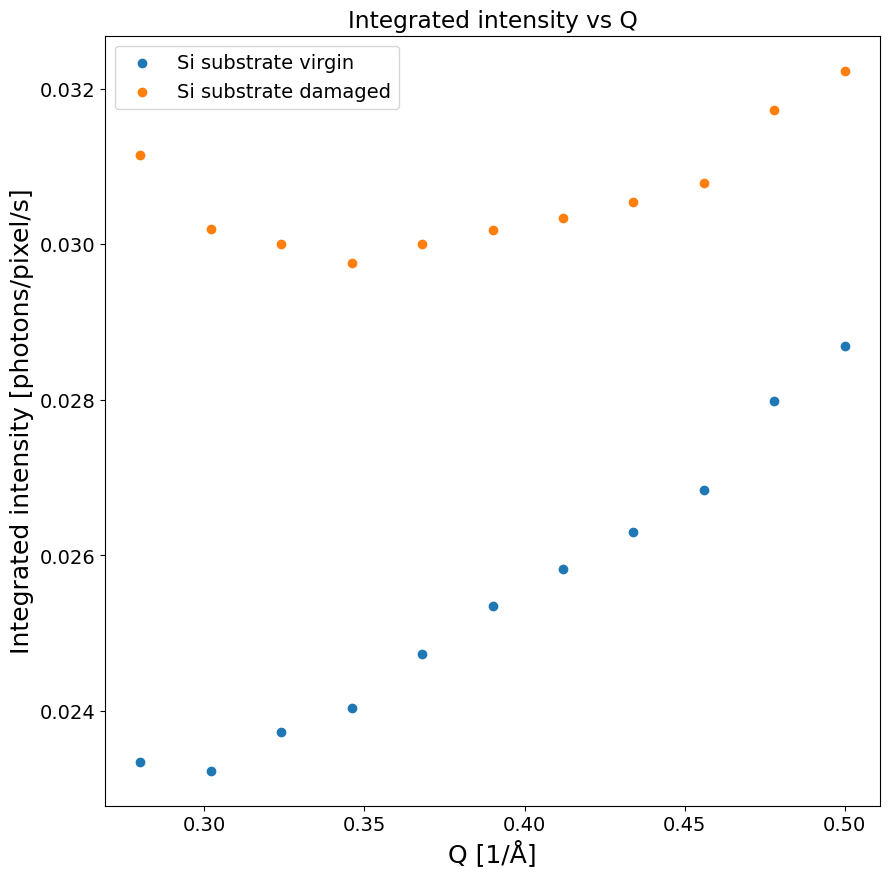

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(Q, Ip_ann.values(),label ='Annealed virgin')
plt.scatter(Q, Ip_ann_damaged.values(), label ='Annealed damaged')
plt.scatter(Q, Ip_asdep.values(), label ='As-deposited virgin')
plt.scatter(Q, Ip_asdep_damaged.values(), label ='As-deposited damaged')
#plt.yscale('log')
plt.xlabel('Q [1/Å]')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.title('Integrated intensity vs Q')
plt.legend()
plt.show()